In [1]:
# encoding: utf-8

import numpy as np
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
import os
import gc
import os
import psutil
import re

from optparse import OptionParser

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing/')
from Metric import *
from Visualization import *
from Data_Extractor import *


parser = OptionParser()
parser.add_option("--dir", dest="dir")
(options, args) = parser.parse_args(["--dir", "./Log/Classifier_Report/"])

log_dir = options.dir

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def get_metric_on_log(log, record):
    line = [s for s in log if ('balanced_acc' in s and 'AUC' in s and 'avg_precision' in s)][0].split()
    assert line[0] == 'balanced_acc' and line[3] == 'AUC' and line[6] == 'avg_precision'
    
    record['BA'] = float(line[2])
    record['AUC'] = float(line[5])
    record['AP'] = float(line[8])
    
    try:
        line = [s for s in log if ('xen' in s)][0].split()
        assert line[0] == 'xen'
        record['xen'] = float(line[-1])
    except:
        record['xen'] = None
        
record_list = []
cnt = 0
for filename in os.listdir(log_dir):
    if 'FCN' not in filename : continue
    cnt += 1
    print(cnt, " : ", filename)

    # open file
    file = open(log_dir+filename)
    log = file.read().split('\n')
    file.close()

    # initialization
    record = {}
    record['train'] = {}
    record['val'] = {}
    record['test'] = {}
    
    # name
    record['name'] = filename

    # setting
    record['conv']   = filename.split('_')[1]
    record['cat']    = filename.split('_cat')[1].split('_')[0]
    record['cur_ep'] = int(filename.split('_r0-')[1].split('-')[0])
    record['ep']     = int(filename.split('_e')[1].split('_')[0])
    
    record['weight'] = filename.find('weight') > 0
    if filename.find('_G') > 0:
        record['norm_T'] = 'std'
    elif filename.find('_m') > 0:
        record['norm_T'] = 'mean'
    else:
        record['norm_T'] = '-'
        
    record['pos'] = int(filename.split('_p')[1].split('_')[0])
    
    if record['ep'] != 100: continue

    try:
        train_idx = log.index("On train set")    
        val_idx = log.index("On cv set")
        test_idx = log.index("On test set")
    
        get_metric_on_log(log[train_idx:val_idx], record['train'])
        get_metric_on_log(log[val_idx:test_idx], record['val'])
        get_metric_on_log(log[test_idx:], record['test'])
        
#         print(record)
        record_list.append(record)
    except:
        print('not finished ---------------')

1  :  FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-21-cpu
2  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e25_r0-22
3  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e100_r0-20-cpu
not finished ---------------
4  :  FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-24-cpu
5  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0-47-cpu
6  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e100_r0-90-cpu
not finished ---------------
7  :  FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-20-cpu
8  :  FCN_64-128-256_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-19-cpu
9  :  FCN_64-128-256_1_cat1-32|1-64|1-128_weight_G_x1_p0_e100_r0-10-cpu
not finished ---------------
10  :  FCN_64-128-256_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-6-cpu
11  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e25_r0-21
12  :  FCN_64-128-256_1_cat1-32|1-64|1-128_weight_G_x1_p0_e100_r0-50-cpu
not finished ---------------
13  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_bn_G_x1_p0_e

In [3]:
sorted_record_list = sorted(record_list, key=lambda r: (r['conv'], r['cat'], r['test']['AUC']))

In [4]:
print("BA: train val test | AP: train val test | AUC: train val test ")
for r in sorted_record_list:
    print("%-6.3f & %-4.3f & %-5.3f & %-6.3f & %-4.3f & %-5.3f & %-6.3f & %-4.3f & %-5.3f \\\\ %% %s %f %f %f" % 
         (r['train']['BA'], r['val']['BA'], r['test']['BA'],
          r['train']['AP'], r['val']['AP'], r['test']['AP'],
          r['train']['AUC'], r['val']['AUC'], r['test']['AUC'],
          r['name'], r['train']['xen'], r['val']['xen'], r['test']['xen']))

BA: train val test | AP: train val test | AUC: train val test 
0.748  & 0.744 & 0.782 & 0.099  & 0.156 & 0.074 & 0.841  & 0.826 & 0.856 \\ % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0-10-cpu 0.014536 0.025929 0.011875
0.771  & 0.755 & 0.757 & 0.122  & 0.187 & 0.082 & 0.859  & 0.846 & 0.858 \\ % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0-20-cpu 0.013544 0.024596 0.012491
0.787  & 0.761 & 0.770 & 0.143  & 0.192 & 0.093 & 0.872  & 0.849 & 0.865 \\ % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0-30-cpu 0.012880 0.024307 0.012023
0.782  & 0.763 & 0.773 & 0.133  & 0.191 & 0.090 & 0.866  & 0.849 & 0.866 \\ % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0-25-cpu 0.013141 0.024198 0.011908
0.797  & 0.754 & 0.764 & 0.163  & 0.188 & 0.101 & 0.885  & 0.848 & 0.866 \\ % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0-43-cpu 0.012347 0.024865 0.012248
0.797  & 0.769 & 0.772 & 0.159  & 0.199 & 0.100 & 0.883  & 0.858 & 0.867 \\ % FCN_32-64-128_

In [ ]:
for r in sorted_record_list:
    print(r['name'])

In [ ]:
selected_list = ['FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-24',
                 'FCN_32-64-128_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19',
                 'FCN_32-64-128_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-24',
                 'FCN_64-128-256_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-19',
                 'FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19',
                 'FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-19']

In [ ]:
file_num = 6
width = 0.1
key_list = ['BA', 'AP', 'AUC']

placement = np.arange(file_num)
print(placement)


for key in key_list:
    fig, ax = plt.subplots(figsize=(9,3))
    cnt = 0
    val_list = []
    name_list = []
    plot_list = []
    for r in sorted_record_list:
        if r['name'] not in selected_list: 
            continue
        cur_val = r['test'][key]

        if r['name'].startswith('FCN_32-64-128'): name = 'A'
        else: name = 'B'
        if '_cat1-32;3-32_' in r['name']: name += '1'
        elif '_cat1-32;3-32|1-32;3-32_' in r['name']: name += '2'
        elif '_cat1-32|1-32|1-32_' in r['name']: name += '3'
        else: print('shen me ji ba wan yi er?')
        name_list.append(name)
        
        cur_placement = placement[cnt]
        cnt+=1
        
        plot_list.append(ax.bar(cur_placement, cur_val, width=width))
    
    ax.set_title(key, fontdict={'fontsize': 20})

    # legend experiment name
    ax.legend(plot_list, name_list)
#     plt.savefig('./Result/FCN_bar'+'_'+key, transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
file_num = 6
width = 0.1
key_list = ['BA', 'AP', 'AUC']

fig, ax = plt.subplots(figsize=(9.5*1.5,3*1.5))
placement = np.arange(len(key_list))
placement = [cnt*0.15 + placement for cnt in range(file_num)]
print(placement)

cnt = 0

name_list = []
plot_list = []
for r in sorted_record_list:

    print('%-30s' % (r['name']), end='')
    if r['name'] not in selected_list: 
        print('%20s' % ('--- skip'))
        continue
    print()
    
    val_list = []
    for key in key_list:
        val_list.append(r['test'][key])

#     if r['pos'] < 8:
#         if r['weight']: name = 'weight'
#         else: name = '-'
#     elif r['pos'] == 8: name = '0.125'
#     elif r['pos'] == 16: name = '0.250'
#     elif r['pos'] == 32: name = '0.500'

    if r['name'].startswith('FCN_32-64-128'): name = 'A'
    else: name = 'B'
    if '_cat1-32;3-32_' in r['name']: name += '1'
    elif '_cat1-32;3-32|1-32;3-32_' in r['name']: name += '2'
    elif '_cat1-32|1-32|1-32_' in r['name']: name += '3'
    else: print('shen me ji ba wan yi er?')
    name_list.append(name)

    plot_list.append(ax.bar(placement[cnt], val_list, width=width))
    cnt += 1

ax.set_xticks((placement[int(cnt/2)] + placement[int(cnt/2)-1])/2)
ax.set_xticklabels(key_list, fontdict={'fontsize': 20})

# legend experiment name
ax.legend([bar[0] for bar in plot_list], name_list)
plt.savefig('./Result/FCN_bar', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

print(plot_list)
print(name_list)

Between Model Cmp

In [12]:
name_list = ['Logistic Regression', 'Agile FCN', 'BridgeUnet']
metric_list = ['weight  & 0.679  & 0.663 & \textbf{0.727} & 0.052  & 0.095 & \textbf{0.066} & 0.752  & 0.765 & \textbf{0.817}',
               'D & 0.799  & 0.792 & \textbf{0.807} & 0.222  & 0.239 & \textbf{0.169} & 0.887  & 0.878 & \textbf{0.893}',
               'B3 & 0.842  & 0.778 & 0.794 & 0.200  & 0.196 & \textbf{0.117} & 0.921  & 0.862 & 0.874']

for idx in range(len(metric_list)):
    cur_metric = []
    for i in metric_list[idx].split():
        if i.startswith('extbf{'):
            i = i.strip('extbf{').strip('}')
        try:
            cur_metric.append(float(i))
        except:
            print('discard', i)
    
    metric_list[idx] = [cur_metric[2], cur_metric[5], cur_metric[8]]
for i in metric_list:
    print(i)

discard weight
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard D
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard B3
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard &
discard &
[0.727, 0.066, 0.817]
[0.807, 0.169, 0.893]
[0.794, 0.117, 0.874]


[array([0., 1., 2.]), array([0.15, 1.15, 2.15]), array([0.3, 1.3, 2.3])]


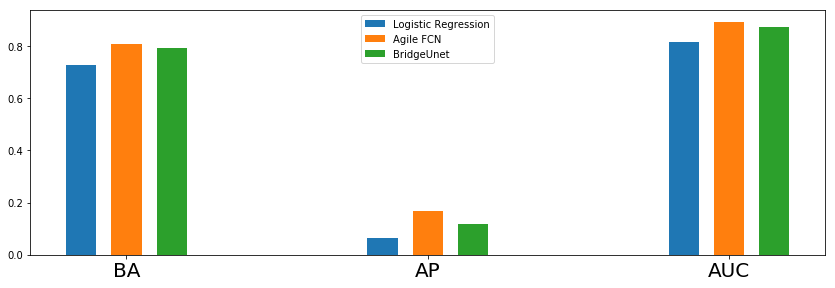

[<Container object of 3 artists>, <Container object of 3 artists>, <Container object of 3 artists>]
['Logistic Regression', 'Agile FCN', 'BridgeUnet']


In [17]:
file_num = 3
width = 0.1
key_list = ['BA', 'AP', 'AUC']

fig, ax = plt.subplots(figsize=(9.5*1.5,3*1.5))
placement = np.arange(len(key_list))
placement = [cnt*0.15 + placement for cnt in range(file_num)]
print(placement)

cnt = 0

plot_list = []
for val_list in metric_list:
    plot_list.append(ax.bar(placement[cnt], val_list, width=width))
    cnt += 1

ax.set_xticks(placement[int(cnt/2)])
ax.set_xticklabels(key_list, fontdict={'fontsize': 20})

# legend experiment name
ax.legend([bar[0] for bar in plot_list], name_list)
plt.savefig('./Result/Cmp-bars', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

print(plot_list)
print(name_list)